# Общая информация

## Краткая информация и цель проекта

HR-аналитики компании помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. 

Первая задача &mdash; построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Это важно, потому что удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

In [1]:
!pip install phik
!pip install shap
!pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import phik
import shap

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import precision_score, make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction import DictVectorizer

In [3]:
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


def pie_diag(df, i):
    plt.figure
    df1 = df.groupby(i)[i].count().sort_values(ascending=False)
    labels = df1.index
    n = len(labels)
    colors = sns.color_palette('pastel')[0:n]
    plt.pie(df1, labels=labels, colors = colors, autopct='%1.1f%%')

In [4]:
RANDOM_STATE = 42

## Первая задача

### Описание данных

Для первой задачи заказчик предоставил файлы:
- train_job_satisfaction_rate.csv;
- test_features.csv;
- test_target_job_satisfaction_rate.csv.

В них хранятся данные о тренировочной выборке, о входных признаках тестовой выборки и о таргете тестовой выборки соответственно.

Входные признаки:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

### План работы

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Корреляционный анализ данных (его нет в плане, но лишним не будет)
5. Построение пайплайна
6. Оформление выводов

### Загрузка данных

In [5]:
X_train_sat = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', na_values=' ')
display(X_train_sat.info())
X_train_sat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
X_test_sat = pd.read_csv('/datasets/test_features.csv', na_values=' ')
display(X_test_sat.info())
X_test_sat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [7]:
y_test_sat_ = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', na_values=' ')
display(y_test_sat_.info())
y_test_sat_.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Промежуточный вывод: датасеты загрузил, увидел пропуски (они все в категориальных признаках), проверил корректность типов данных. Что нужно будет сделать далее? Нужно будет соединить **X_test** и **y_test** по _id_, а потом заново их разделить, чтобы в датасетах данные о человеке совпадали по строкам. Проверить на явные и неявные дубликаты. Пропуски заполню в пайплайне модой.

### Предобработка данных

In [8]:
_ = pd.merge(X_test_sat, y_test_sat_, how='inner', on='id')
_

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.56
1996,109582,technology,middle,low,3,no,no,2,21600,0.14
1997,305653,technology,junior,low,1,no,no,3,14400,0.11
1998,160233,technology,middle,low,8,no,no,1,32400,0.43


In [9]:
y_test_sat = _['job_satisfaction_rate']
y_test_sat

0       0.79
1       0.72
2       0.64
3       0.60
4       0.75
        ... 
1995    0.56
1996    0.14
1997    0.11
1998    0.43
1999    0.67
Name: job_satisfaction_rate, Length: 2000, dtype: float64

In [10]:
X_train_sat = X_train_sat.drop_duplicates() # удалил явные дубликаты
X_test_sat = X_test_sat.drop_duplicates() # удалил явные дубликаты

Дальше проверю на неявные дубликаты.

In [11]:
cat_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
for i in cat_columns:
    display(X_train_sat[i].value_counts())

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

junior    1894
middle    1744
sinior     358
Name: level, dtype: int64

medium    2066
low       1200
high       734
Name: workload, dtype: int64

no     3880
yes     120
Name: last_year_promo, dtype: int64

no     3441
yes     559
Name: last_year_violations, dtype: int64

In [12]:
for i in cat_columns:
    display(X_test_sat[i].value_counts())

sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64

junior    974
middle    854
sinior    171
Name: level, dtype: int64

medium    1043
low        593
high       363
Name: workload, dtype: int64

no     1937
yes      63
Name: last_year_promo, dtype: int64

no     1738
yes     262
Name: last_year_violations, dtype: int64

Промежуточный вывод: неявных дубликатов не обнаружил, пропуски заполню модой в пайплайне. Изменять типы данных не требовалось.

### Исследовательский анализ данных

Сначала построю круговые диаграммы для категориальных переменных.

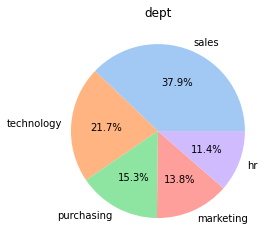

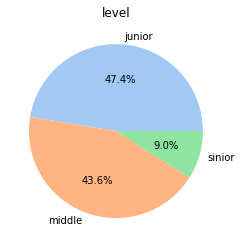

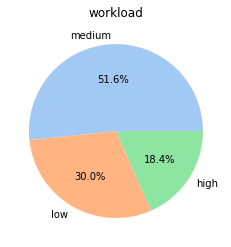

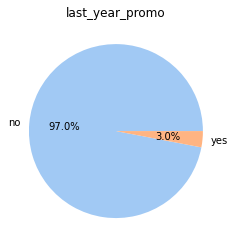

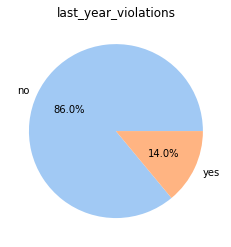

In [13]:
for i in cat_columns:
    plt.title(i)
    pie_diag(X_train_sat, i)
    plt.show()

In [14]:
num_columns = X_train_sat.columns.to_list()
num_columns = [x for x in num_columns if x not in cat_columns]
num_columns.remove('id')
num_columns

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

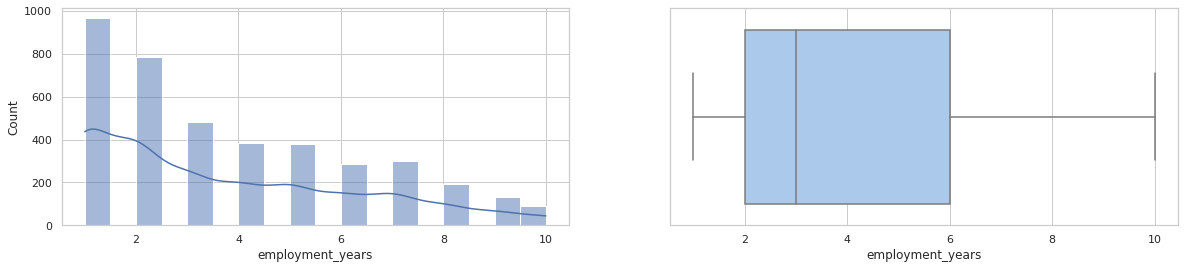

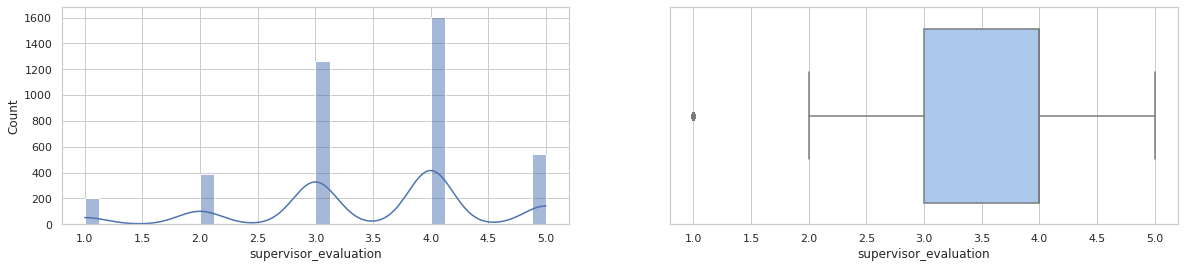

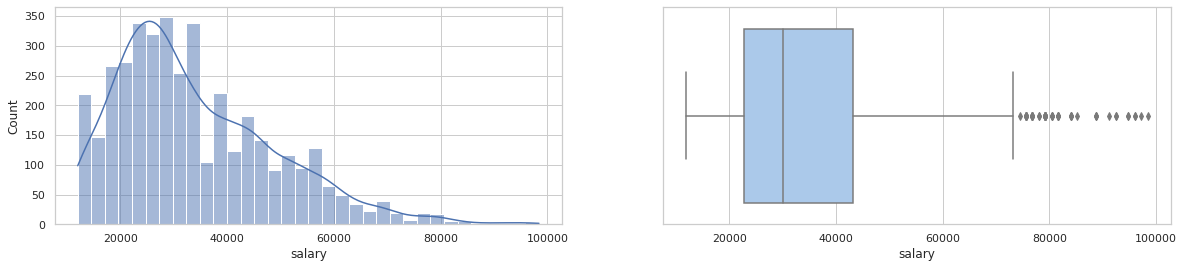

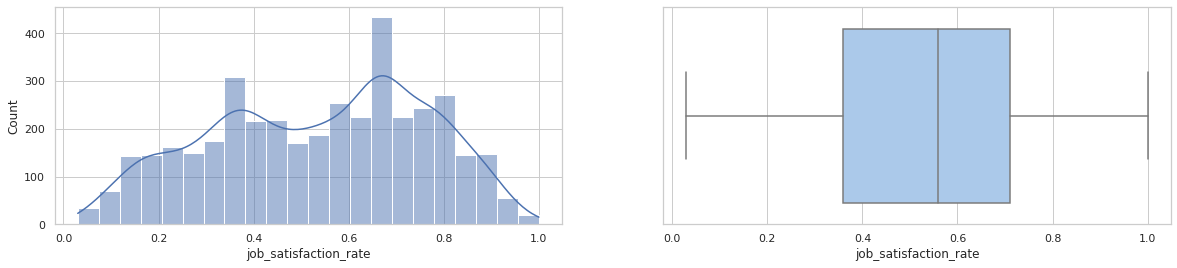

In [15]:
for i in num_columns:
    plt.rcParams['figure.figsize'] = [20, 4]
    sns.set(style='whitegrid')
    plt.subplot(1, 2, 1)
    sns.histplot(data = X_train_sat, x = X_train_sat[i], kde=True)
    plt.subplot(1, 2, 2)
    sns.boxplot(data = X_train_sat, x = X_train_sat[i], palette='pastel')
    plt.show()

Промежуточный вывод: вижу выбросы на боксплотах, но они не похожи на аномалии $\Rightarrow$ не буду удалять их. Может, они будут сигнализировать какие-то тенденции.

### Корреляционный анализ данных

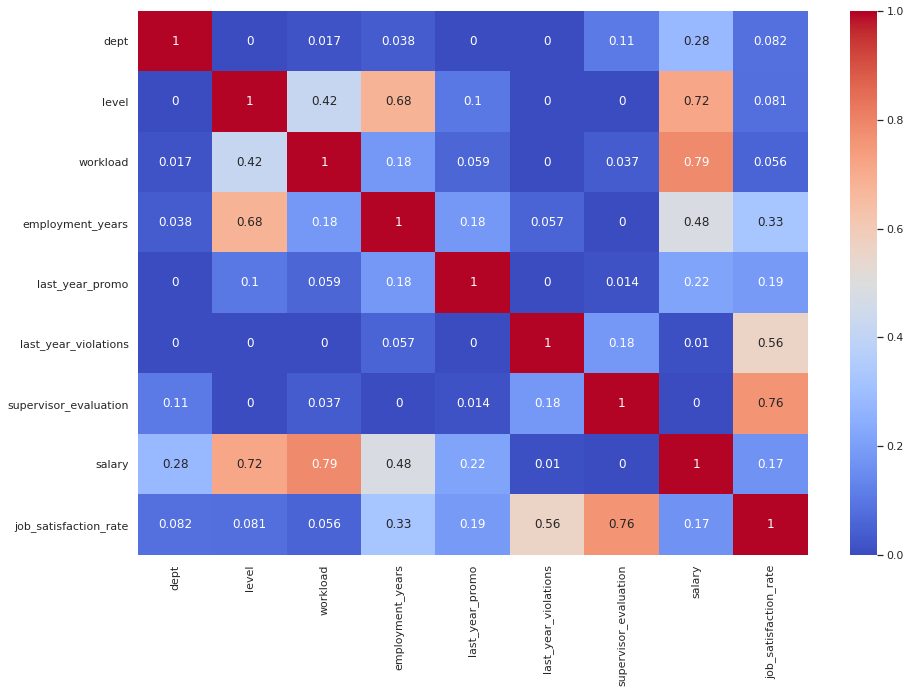

In [16]:
plt.figure(figsize=(15, 10))
sns.heatmap(X_train_sat.drop('id', axis=1).phik_matrix(interval_cols=num_columns), annot=True, cmap='coolwarm')
plt.show()

Промежуточный вывод: есть три пары признаков с подозрением на мультиколлинеарность. Но мне кажется, что никакой из признаков удалять не стоит, так как они все важны для построения модели.

### Построение пайплайна

In [17]:
y_train_sat = X_train_sat['job_satisfaction_rate']
X_train_sat = X_train_sat.drop(['id', 'job_satisfaction_rate'], axis=1)
X_test_sat = X_test_sat.drop(['id'], axis=1)

In [18]:
cat_columns

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [19]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = X_train_sat.columns.to_list()
num_columns = [x for x in num_columns if x not in cat_columns]

In [20]:
num_columns

['employment_years', 'supervisor_evaluation', 'salary']

In [21]:
smape_score = make_scorer(smape, greater_is_better=False)

In [22]:
warnings.filterwarnings('ignore')

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для SVC()
    {
        'models': [SVC()],
        'models__kernel': ['rbf', 'sigmoid', 'linear', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_sat, y_train_sat)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

y_test_sat_pred = randomized_search.predict(X_test_sat)
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test_sat, y_test_sat_pred)}')


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                       

### Выводы по первой задаче

Лучше других справилась модель дерева решений. Думаю, что это связано с нелинейностью входных данных.

## Вторая задача

### Описание данных

Файлы для второй задачи:
- train_quit.csv;
- test_features.csv;
- test_target_quit.csv.

В них хранятся данные о тренировочной выборке, о входных признаках тестовой выборки и о таргете тестовой выборки соответственно.

Входные признаки:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- quit — увольнение сотрудника из компании.


### План работы

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Корреляционный анализ данных (его нет в плане, но лишним не будет)
5. Добавление нового входного признака
6. Построение пайплайна
7. Оформление выводов

### Загрузка данных

In [23]:
X_train_quit = pd.read_csv('/datasets/train_quit.csv', na_values=' ')
display(X_train_quit.info())
X_train_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [24]:
#X_test тот же самый
X_test_quit = pd.read_csv('/datasets/test_features.csv', na_values=' ')

In [25]:
y_test_quit_ = pd.read_csv('/datasets/test_target_quit.csv')
display(y_test_quit_.info())
y_test_quit_.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Промежуточный вывод: пропуски есть только в **X_test**, их заполню модой в пайплайне. Надо правильно упорядочить **y_test_quit**, закодировать таргет в датасетах, удалить дубликаты.

### Предобработка данных

In [26]:
X_train_quit['quit'] = X_train_quit['quit'].replace(['yes', 'no'], [0, 1])
_ = pd.merge(X_test_quit, y_test_quit_, how='inner', on='id')
_['quit'] = _['quit'].replace(['yes', 'no'], [0, 1])
_

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,1
1,686555,hr,junior,medium,1,no,no,4,30000,1
2,467458,sales,middle,low,5,no,no,4,19200,1
3,418655,sales,middle,low,6,no,no,4,19200,1
4,789145,hr,middle,medium,5,no,no,5,40800,1
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0
1996,109582,technology,middle,low,3,no,no,2,21600,0
1997,305653,technology,junior,low,1,no,no,3,14400,0
1998,160233,technology,middle,low,8,no,no,1,32400,1


In [27]:
y_test_quit = _['quit']
y_test_quit

0       1
1       1
2       1
3       1
4       1
       ..
1995    0
1996    0
1997    0
1998    1
1999    1
Name: quit, Length: 2000, dtype: int64

In [28]:
X_train_quit = X_train_quit.drop_duplicates()
X_test_quit = X_test_quit.drop_duplicates()

Проверю на неявные дубликаты.

In [29]:
cat_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
target = 'quit'
for i in cat_columns:
    display(X_train_quit[i].value_counts())
display(X_train_quit[target].value_counts())

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

junior    1949
middle    1694
sinior     357
Name: level, dtype: int64

medium    2118
low       1208
high       674
Name: workload, dtype: int64

no     3887
yes     113
Name: last_year_promo, dtype: int64

no     3455
yes     545
Name: last_year_violations, dtype: int64

1    2872
0    1128
Name: quit, dtype: int64

**X_test_quit** (он же **X_test_sat**) уже проверял на неявные дубликаты.

Промежуточный вывод: неявных дубликатов не обнаружил, пропуски заполню модой в пайплайне. Изменять типы данных не требовалось.

### Исследовательский анализ данных

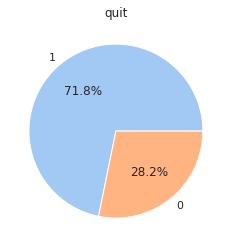

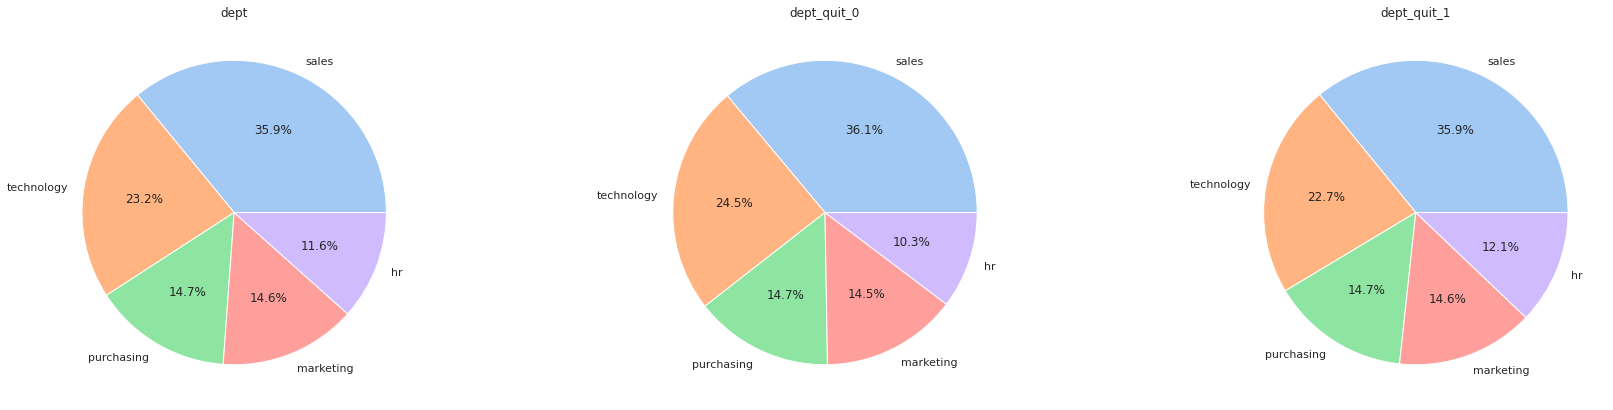

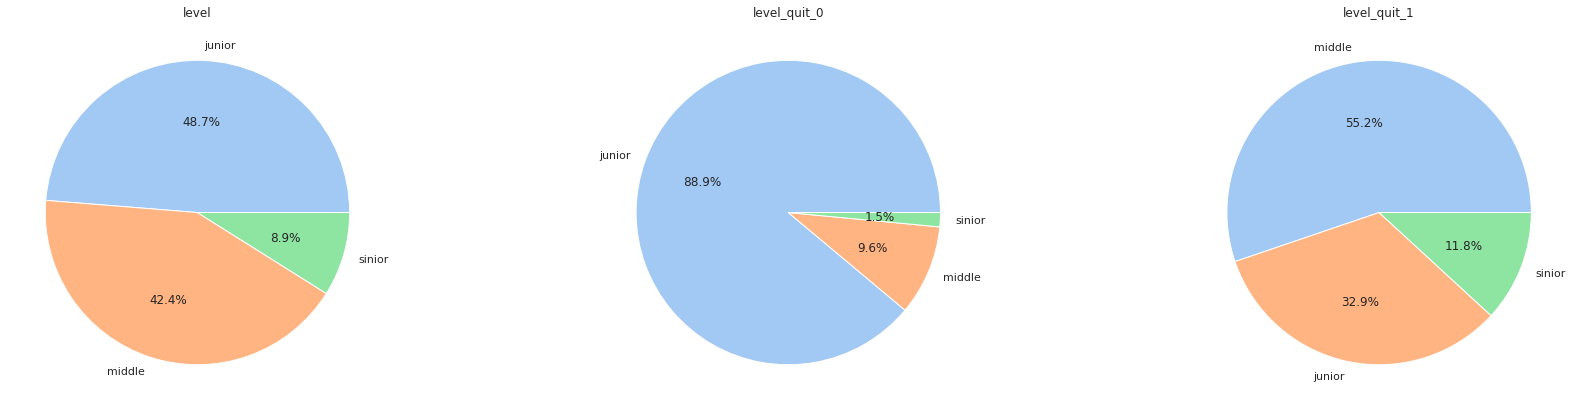

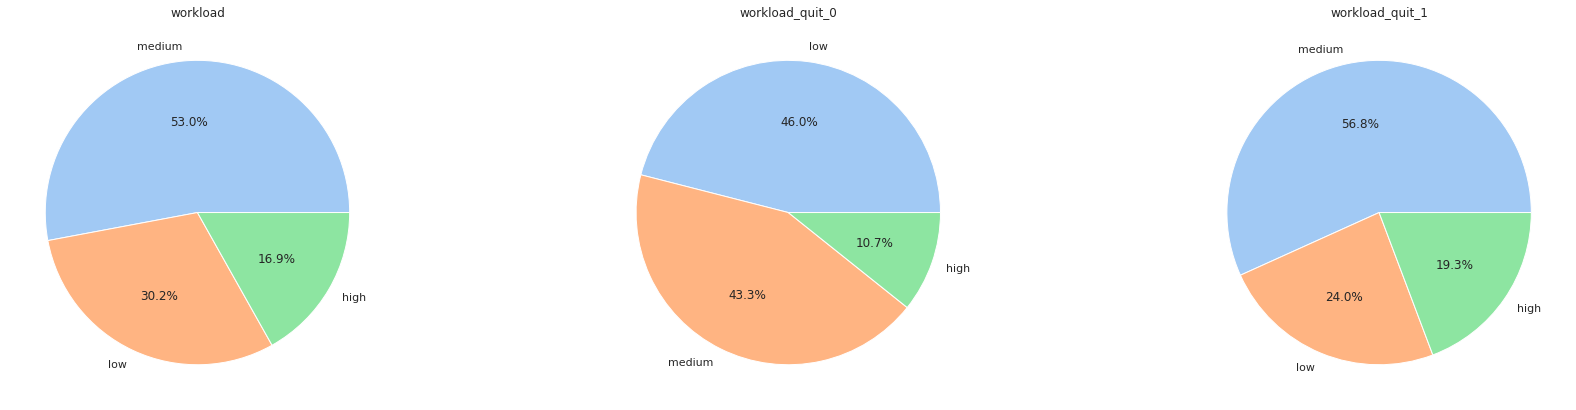

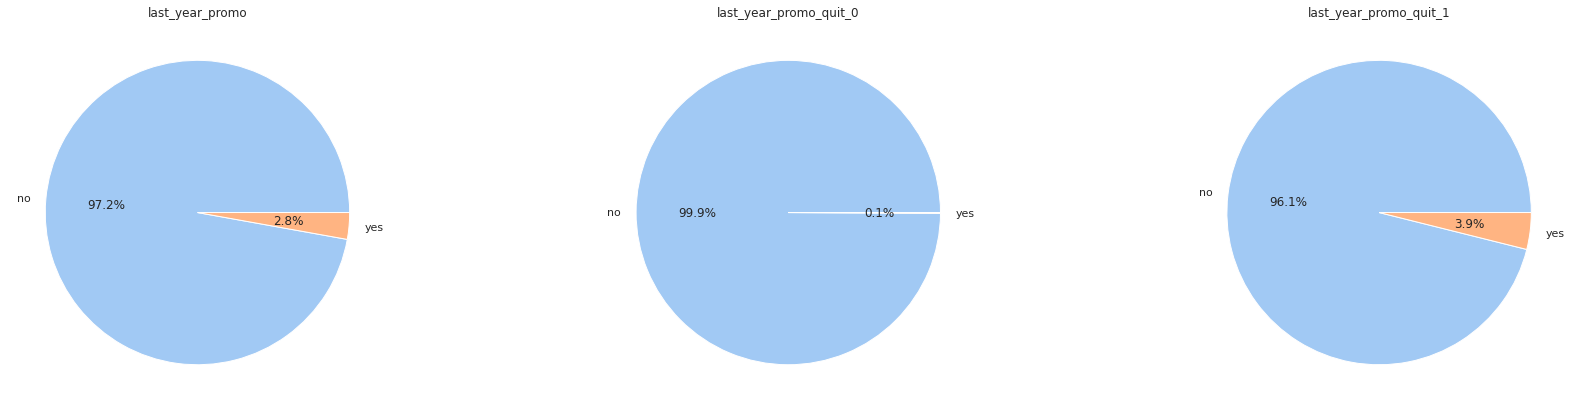

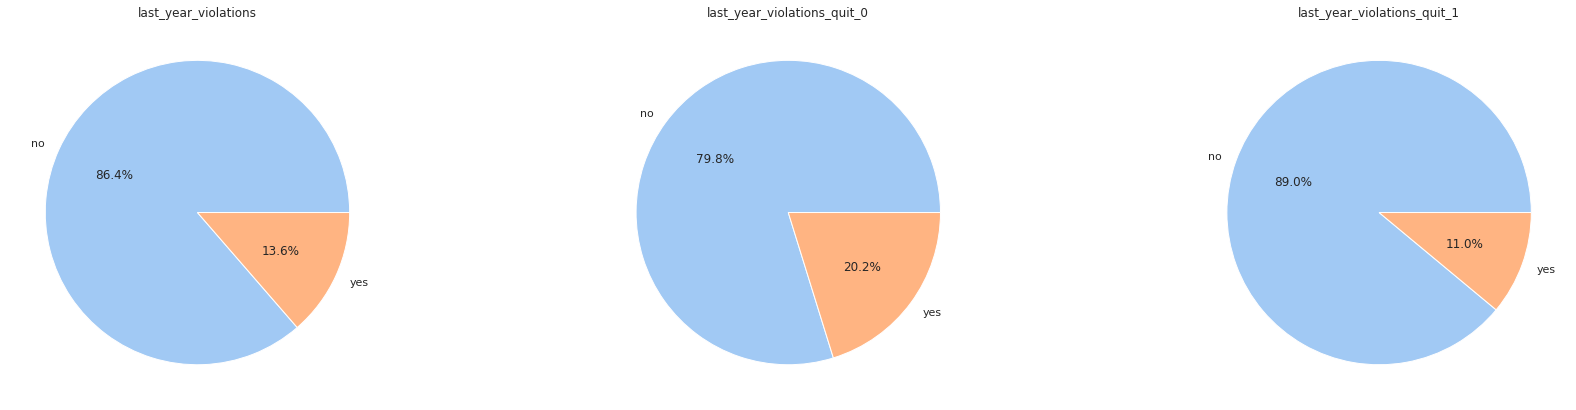

In [30]:
plt.title(target)
pie_diag(X_train_quit, target)
plt.show()
plt.rcParams['figure.figsize'] = [30, 7]
for i in cat_columns:
    plt.subplot(1, 3, 1)
    plt.title(i)
    pie_diag(X_train_quit, i)
    plt.subplot(1, 3, 2)
    plt.title(i+'_quit_0')
    pie_diag(X_train_quit[X_train_quit[target] == 0], i)
    plt.subplot(1, 3, 3)
    plt.title(i+'_quit_1')
    pie_diag(X_train_quit[X_train_quit[target] == 1], i)
    plt.show()

Составим "портрет" увольняющихся сотрудников.

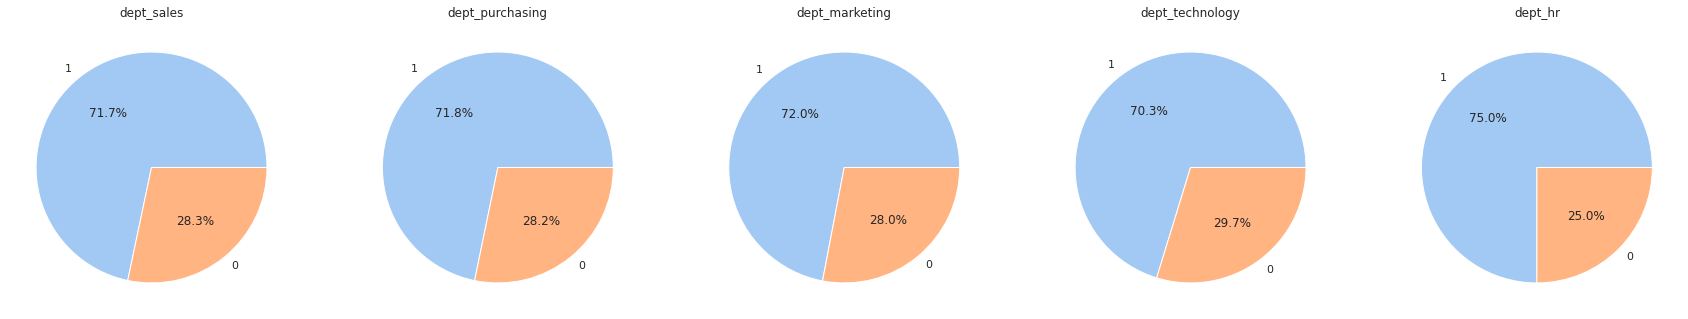

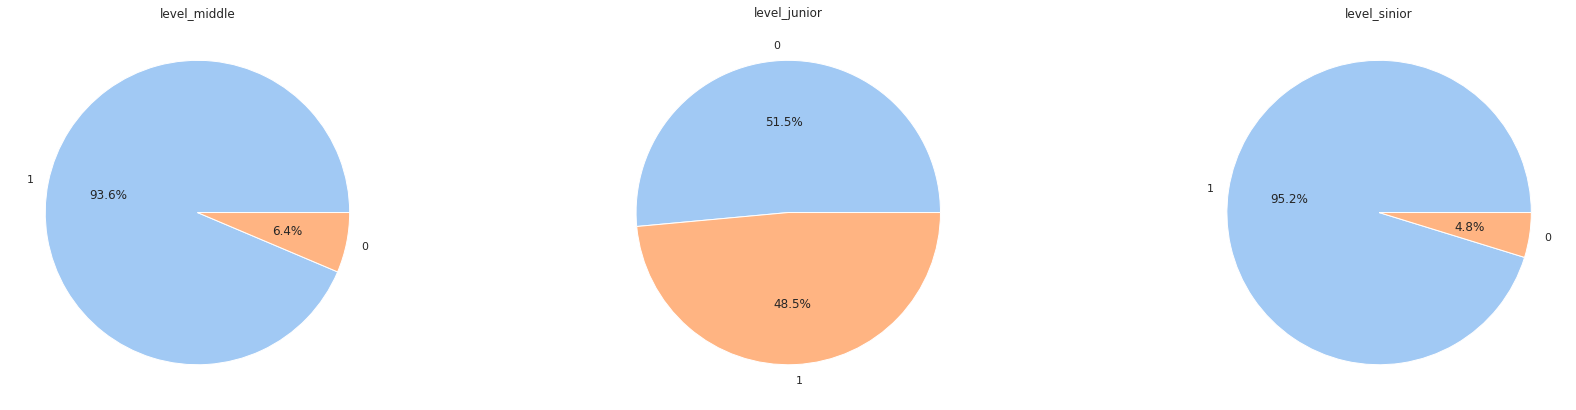

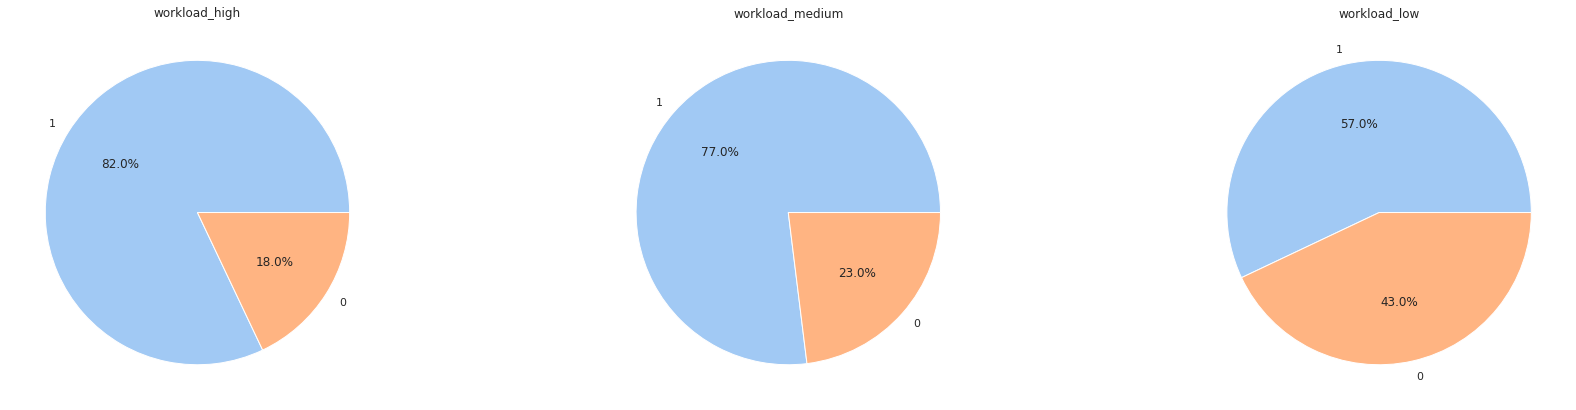

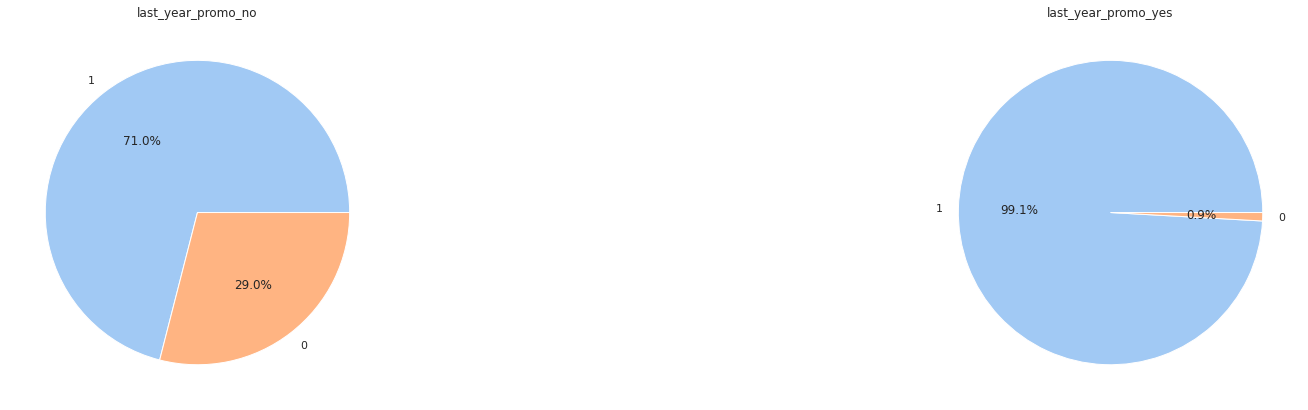

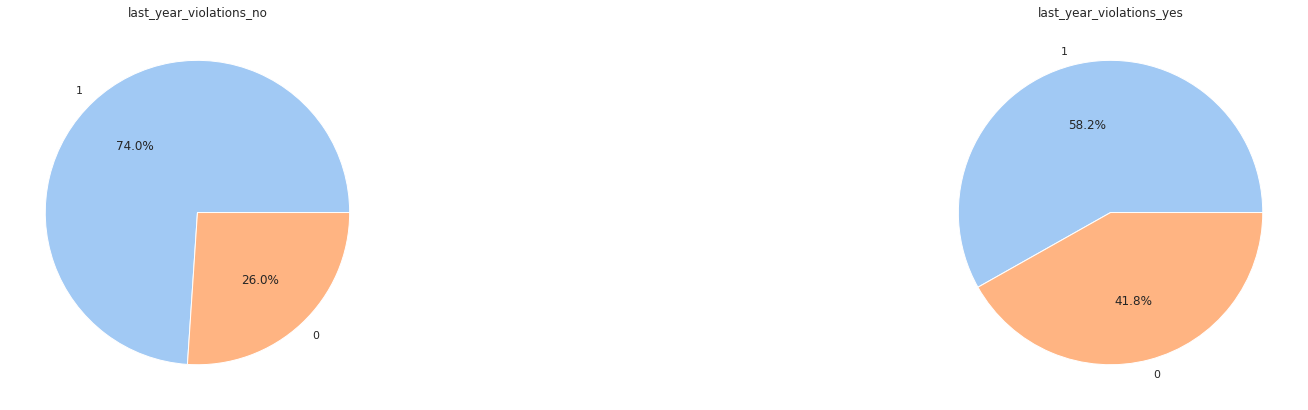

In [31]:
for i in cat_columns:
    for j in range(len(X_train_quit[i].unique())):
        plt.rcParams['figure.figsize'] = [30, 7]
        plt.subplot(1, len(X_train_quit[i].unique()), j+1)
        plt.title(i+'_'+X_train_quit[i].unique()[j])
        pie_diag(X_train_quit[X_train_quit[i] == X_train_quit[i].unique()[j]], target)
    plt.show()

Можно сделать вывод, что департамент, в котором работает сотрудник, не сильно влияет на решение об уходе. Если сотрудник middle или sinior, то он уйдет с большей вероятностью (возможно компания не может удовлетворить зарплатные потребности таких сотрудников). Если же в течение года у сотрудника были повышения, то он примет решение об уходе в 99 / 100 случаев.

In [32]:
num_columns = X_train_quit.columns.to_list()
num_columns = [x for x in num_columns if x not in cat_columns]
num_columns.remove('id')
num_columns.remove(target)
num_columns

['employment_years', 'supervisor_evaluation', 'salary']

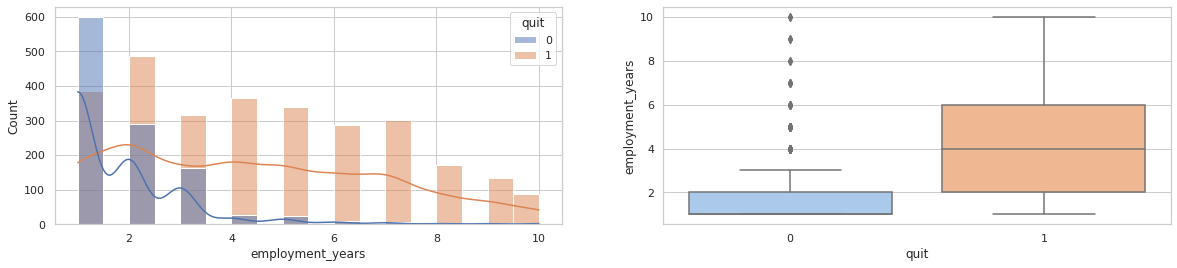

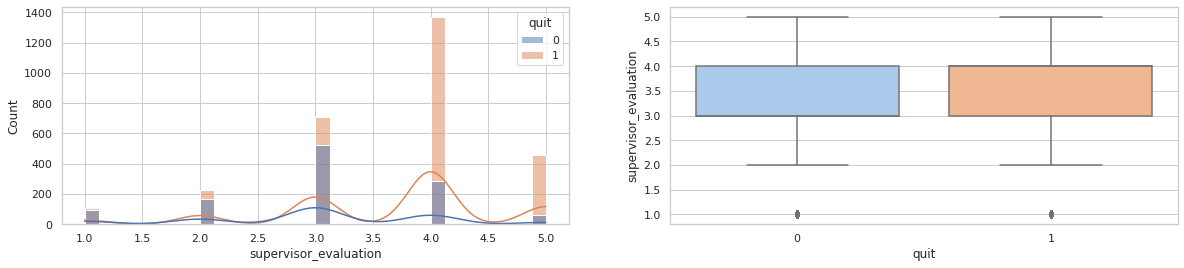

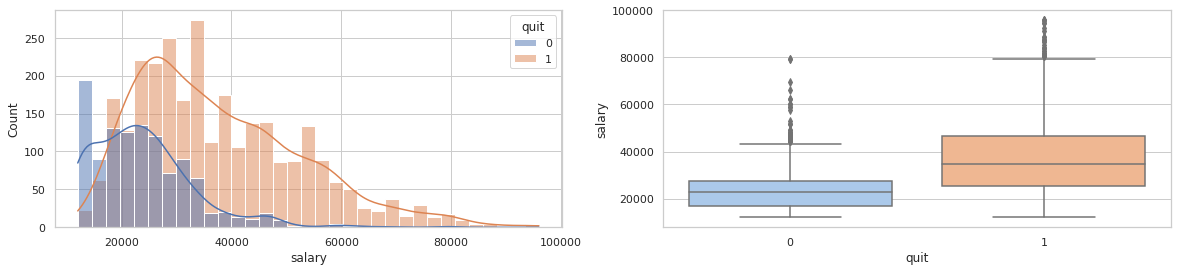

In [33]:
plt.rcParams['figure.figsize'] = [20, 4]
for i in num_columns:
    sns.set(style='whitegrid')
    plt.subplot(1, 2, 1)
    sns.histplot(data = X_train_quit, x = X_train_quit[i], hue = target, kde=True)
    plt.subplot(1, 2, 2)
    sns.boxplot(data = X_train_quit, y = X_train_quit[i], x = X_train_quit[target], palette='pastel')
    plt.show()

Промежуточный вывод: все выбросы в данных не являются аномалиями, поэтому удалять их не стоит. Общая картина такая &mdash; увольняются сотрудники с большим опытом, большей зарплатой (в среднем).

### Корреляционный анализ данных

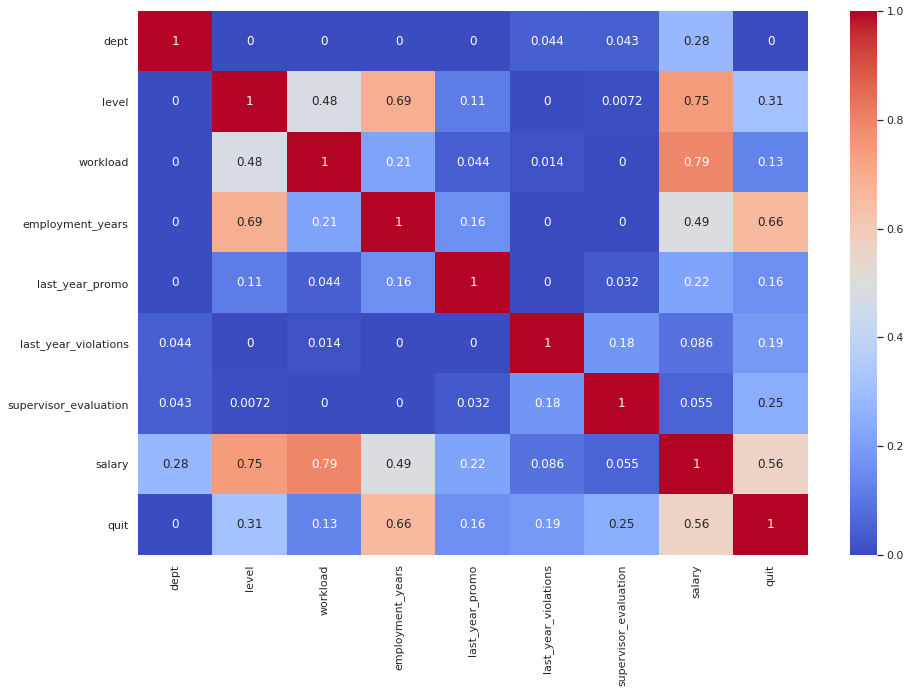

In [34]:
plt.figure(figsize=(15, 10))
sns.heatmap(X_train_quit.drop('id', axis=1).phik_matrix(interval_cols=num_columns), annot=True, cmap='coolwarm')
plt.show()

Сначала хотел построить матрицы с разбивкой по таргету, но после разбивки получаю предупреждение о малом количестве значений, матрица строится без таргета вовсе.

Промежуточный вывод: есть пары с подозрением на мультиколлинеарность, но, повторюсь, мне кажется, что стоит все признаки оставить.

### Добавление нового входного признака

In [35]:
y_train_quit = X_train_quit[target]
X_train_quit = X_train_quit.drop(['id', target], axis=1)
X_test_quit = X_test_quit.drop(['id'], axis=1)

In [36]:
y_train_quit

0       1
1       1
2       1
3       0
4       1
       ..
3995    1
3996    1
3997    0
3998    1
3999    0
Name: quit, Length: 4000, dtype: int64

In [37]:
X_train_quit['job_satisfaction_rate'] = randomized_search.predict(X_train_quit)
X_train_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,0.631429
1,sales,junior,medium,2,no,no,4,27600,0.826111
2,purchasing,middle,medium,5,no,no,1,37200,0.353333
3,sales,junior,medium,2,no,yes,3,24000,0.380000
4,marketing,junior,medium,2,no,no,5,25200,0.690000
...,...,...,...,...,...,...,...,...,...
3995,sales,junior,medium,4,no,no,3,26400,0.523158
3996,sales,middle,high,9,no,no,4,52800,0.820312
3997,purchasing,junior,low,2,no,yes,4,12000,0.520000
3998,purchasing,middle,medium,2,no,no,4,33600,0.580000


In [38]:
X_test_quit['job_satisfaction_rate'] = randomized_search.predict(X_test_quit)

### Построение пайплайна

In [39]:
display(ohe_columns)
display(ord_columns)
num_columns.append('job_satisfaction_rate')
display(num_columns)

['dept', 'last_year_promo', 'last_year_violations']

['level', 'workload']

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

In [40]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            penalty='l2'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для SVC()
    {
        'models': [SVC()],
        'models__kernel': ['rbf','sigmoid', 'linear', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_quit, y_train_quit)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

y_test_quit_pred = randomized_search.predict_proba(X_test_quit)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_quit, y_test_quit_pred[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                       

Значение метрики недостаточное. Замечу, что из корреляционного анализа можно заключить, что признак _dept_ вообще не коррелирует с таргетом, попробую удалить этот столбец.

  0%|          | 0/2000 [00:00<?, ?it/s]

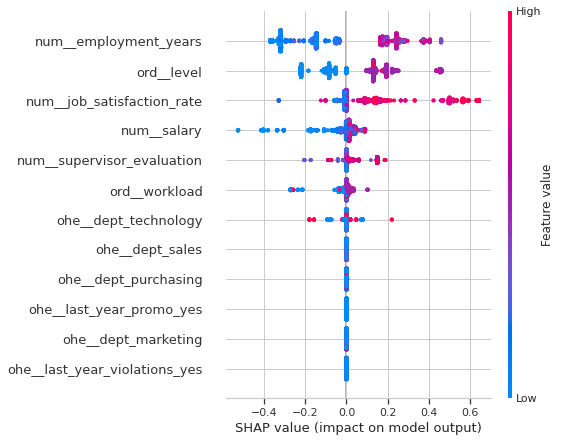

In [44]:
model = randomized_search.best_estimator_.named_steps['models']
pre = randomized_search.best_estimator_.named_steps['preprocessor']
ar = pre.transform(X_test_quit)
names = pre.get_feature_names_out()
df = pd.DataFrame(data=ar, columns=names)

X_test_summary = shap.kmeans(df, 10)

ex = shap.KernelExplainer(model.predict, X_test_summary)
shap_values = ex.shap_values(df)
shap.summary_plot(shap_values, df)

Удалим наименее важные признаки и заново посчитаем метрику.

### Выводы по второй задаче

Лучше других справилась модель дерева решений. Думаю, что это связано с нелинейностью входных данных.

## Общий вывод

Передо мною было поставлено две задачи: регрессии и классификации. Вторая, на мой взгляд была более важной, так как в конечном итоге важен результат &mdash; уволится сотрудник или нет. 

Для решения задачи надо было обработать несколько датасетов, заполнить пропуски в них, закодировать данные. После надо было построить модели, которые могут решить поставленные задачи с нужным показателем метрики.

В работе также провел анализ входных признаков. 

Основываясь на нем, можно дать несколько советов заказчику. Больше всего на уход влияет количество лет, которое сотрудник провел в данной компании: чем больше, тем вероятнее. С возрастом также коррелирует и уровень сотрудника &mdash; если человек долго работает в компании, то постепенно растет в своей професии. Почти все middle и sinior уходят. Можно посоветовать давать стажеров таким сотрудникам, чтобы они сами готовили себе замену на случай ухода.